In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import model_selection, linear_model
from sklearn.impute import SimpleImputer
import util

In [2]:
# Path: data-processing.ipynb
# Read in the data
df = pd.read_csv('data/application_train.csv')
df.head(15)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,100009,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,100010,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,100012,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Removes columns we first deemed are useless
util.defaultClean(df)
target = df["TARGET"]
df.drop(columns = ["TARGET"], inplace=True)

In [4]:
bureau = pd.read_csv('data/bureau.csv')
bureau = bureau[bureau["CREDIT_CURRENCY"] == "currency 1"]
bureau.drop(columns = ["SK_ID_BUREAU", "CREDIT_ACTIVE", "CREDIT_CURRENCY", "DAYS_CREDIT", "CREDIT_DAY_OVERDUE", "DAYS_CREDIT_ENDDATE", "DAYS_ENDDATE_FACT", "CREDIT_TYPE", "DAYS_CREDIT_UPDATE", "AMT_ANNUITY"], inplace=True)
bureau.fillna(0, inplace=True)
bureau["CREDIT_BUREAU_APPLICATION_COUNT"] = 1
bureau.sort_values(by=["SK_ID_CURR"], inplace=True)
bureau = bureau.groupby("SK_ID_CURR").mean()
df = df.merge(bureau, how="left", on="SK_ID_CURR")

In [5]:
prev = pd.read_csv('data/previous_application.csv')
prev.drop(columns=["SK_ID_PREV", "NAME_CONTRACT_TYPE", "WEEKDAY_APPR_PROCESS_START", "HOUR_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY",
                   "AMT_DOWN_PAYMENT", "AMT_GOODS_PRICE", "RATE_INTEREST_PRIMARY", "RATE_INTEREST_PRIVILEGED",
                   "NAME_CASH_LOAN_PURPOSE", "DAYS_DECISION", "NAME_TYPE_SUITE", "NAME_GOODS_CATEGORY", "NAME_PORTFOLIO", "NAME_PRODUCT_TYPE", "CHANNEL_TYPE", "SELLERPLACE_AREA", "NAME_SELLER_INDUSTRY", "CNT_PAYMENT",
                   "PRODUCT_COMBINATION", "DAYS_FIRST_DRAWING", "DAYS_FIRST_DUE", "DAYS_LAST_DUE_1ST_VERSION", "DAYS_LAST_DUE", "DAYS_TERMINATION"], inplace=True)
prev = prev[prev["NAME_CONTRACT_STATUS"] != "Canceled"]
prev.fillna(0, inplace=True)
prev["TIME_TO_PAY"] = np.where(prev["AMT_ANNUITY"] == 0, 0, prev["AMT_CREDIT"] / prev["AMT_ANNUITY"])
prev["AMT_CREDIT"] = np.where(prev["NAME_CONTRACT_STATUS"] == "Refused", 0, prev["AMT_CREDIT"])
prev["CREDIT_DIFFERENCE"] = prev["AMT_CREDIT"] - prev["AMT_APPLICATION"]
prev.drop(columns=["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT"], inplace=True)

str_columns = prev.select_dtypes(['string', "object"]).columns
prev[str_columns] = prev[str_columns].astype("category")
cat_columns = prev.select_dtypes(['category']).columns
prev = util.onehot_categorical_columns(prev, cat_columns)
prev.replace({False: 0, True: 1}, inplace=True)

prev1 = prev[["SK_ID_CURR", "RATE_DOWN_PAYMENT", "NFLAG_INSURED_ON_APPROVAL", "TIME_TO_PAY", "CREDIT_DIFFERENCE"]]
prev2 = prev.drop(columns=["RATE_DOWN_PAYMENT", "NFLAG_INSURED_ON_APPROVAL", "TIME_TO_PAY", "CREDIT_DIFFERENCE"])
prev1 = prev1.groupby("SK_ID_CURR").agg(
    AVG_DOWN_PAYMENT=pd.NamedAgg(column="RATE_DOWN_PAYMENT", aggfunc="mean"),
    NUM_INSURED=pd.NamedAgg(column="NFLAG_INSURED_ON_APPROVAL", aggfunc="sum"),
    AVG_MONTHS_TO_PAY=pd.NamedAgg(column="TIME_TO_PAY", aggfunc="mean"),
    TOTAL_CREDIT_DIFFERENCE=pd.NamedAgg(column="CREDIT_DIFFERENCE", aggfunc="sum"),
)
prev2 = prev2.groupby("SK_ID_CURR").sum()
prev = prev1.merge(prev2, how="inner", on="SK_ID_CURR")
df = df.merge(prev, how="left", on="SK_ID_CURR")
df.head(15)
# prev.sort_values(by=["SK_ID_CURR"], inplace=True)
# prev["NAME_CONTRACT_STATUS"].value_counts(normalize=True)
# prev.head(15)
# prev[prev["NAME_CONTRACT_STATUS"] == "Unused offer"]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CODE_REJECT_REASON_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
0,100002,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,100003,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,...,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
2,100004,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,100006,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,297000.0,...,0.0,1.0,0.0,5.0,0.0,1.0,2.0,0.0,2.0,1.0
4,100007,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,513000.0,...,0.0,1.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,3.0
5,100008,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,454500.0,...,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,3.0,1.0
6,100009,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,1395000.0,...,0.0,0.0,1.0,6.0,0.0,0.0,2.0,1.0,1.0,3.0
7,100010,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,1530000.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,100011,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,913500.0,...,0.0,1.0,0.0,3.0,0.0,2.0,1.0,1.0,0.0,0.0
9,100012,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,405000.0,...,0.0,1.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0


In [6]:
df.drop(columns = ["SK_ID_CURR"], inplace=True)

In [7]:
# All columns with NaNs
df2 = df.loc[:, df.isnull().any()]
print("numCols: ", len(df2.columns))
df2.columns

numCols:  103


Index(['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE',
       'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG',
       ...
       'CODE_REJECT_REASON_XNA', 'NAME_CLIENT_TYPE_New',
       'NAME_CLIENT_TYPE_Refreshed', 'NAME_CLIENT_TYPE_Repeater',
       'NAME_CLIENT_TYPE_XNA', 'NAME_YIELD_GROUP_XNA', 'NAME_YIELD_GROUP_high',
       'NAME_YIELD_GROUP_low_action', 'NAME_YIELD_GROUP_low_normal',
       'NAME_YIELD_GROUP_middle'],
      dtype='object', length=103)

In [8]:
# Calculates percentage of NaNs alongside data type of column
percentNull = {}
for col in df.columns:
    percent = (len(df[df[col].isnull()]))/len(df)
    if percent > 0:
        percentNull[col] = (df.dtypes[col], percent)
percentNull

{'AMT_ANNUITY': (dtype('float64'), 3.9022994299390916e-05),
 'AMT_GOODS_PRICE': (dtype('float64'), 0.0009040327012692228),
 'NAME_TYPE_SUITE': (dtype('O'), 0.004201475719567756),
 'OWN_CAR_AGE': (dtype('float64'), 0.6599081008484249),
 'OCCUPATION_TYPE': (dtype('O'), 0.31345545362604915),
 'CNT_FAM_MEMBERS': (dtype('float64'), 6.503832383231819e-06),
 'EXT_SOURCE_1': (dtype('float64'), 0.5638107254699832),
 'EXT_SOURCE_2': (dtype('float64'), 0.0021462646864665006),
 'EXT_SOURCE_3': (dtype('float64'), 0.19825307062186392),
 'APARTMENTS_AVG': (dtype('float64'), 0.5074972927797705),
 'BASEMENTAREA_AVG': (dtype('float64'), 0.5851595552679416),
 'YEARS_BEGINEXPLUATATION_AVG': (dtype('float64'), 0.48781019215572774),
 'YEARS_BUILD_AVG': (dtype('float64'), 0.6649778381911542),
 'COMMONAREA_AVG': (dtype('float64'), 0.6987229725115525),
 'ELEVATORS_AVG': (dtype('float64'), 0.532959796560123),
 'ENTRANCES_AVG': (dtype('float64'), 0.503487680115508),
 'FLOORSMAX_AVG': (dtype('float64'), 0.4976082

In [9]:
# Shows all rows where a certain column has NaNs
df[df['EXT_SOURCE_2'].isnull()]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,CODE_REJECT_REASON_XNA,NAME_CLIENT_TYPE_New,NAME_CLIENT_TYPE_Refreshed,NAME_CLIENT_TYPE_Repeater,NAME_CLIENT_TYPE_XNA,NAME_YIELD_GROUP_XNA,NAME_YIELD_GROUP_high,NAME_YIELD_GROUP_low_action,NAME_YIELD_GROUP_low_normal,NAME_YIELD_GROUP_middle
329,Cash loans,M,N,N,2,157500.0,239850.0,25447.5,225000.0,Unaccompanied,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,2.0,1.0,0.0
349,Cash loans,F,N,Y,0,81000.0,276277.5,21825.0,238500.0,Unaccompanied,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
617,Cash loans,F,N,Y,0,180000.0,533668.5,22738.5,477000.0,Unaccompanied,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1028,Cash loans,F,Y,Y,0,121500.0,909000.0,36180.0,909000.0,Unaccompanied,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1520,Cash loans,M,Y,Y,0,225000.0,269550.0,21294.0,225000.0,Unaccompanied,...,0.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305775,Cash loans,F,N,N,1,225000.0,566055.0,18387.0,472500.0,Unaccompanied,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
306208,Cash loans,M,N,Y,0,112500.0,562491.0,23832.0,454500.0,Unaccompanied,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306235,Cash loans,F,N,Y,0,112500.0,343800.0,16155.0,225000.0,Unaccompanied,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
307029,Cash loans,F,Y,N,2,153000.0,808650.0,26217.0,675000.0,Unaccompanied,...,0.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0


In [10]:
# Y'ALL, WE'RE DUMB AS SHIT. Check this out:
col_descriptions = pd.read_csv('data/HomeCredit_columns_description.csv', encoding = "ISO-8859-1")
col_descriptions.head(20)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
5,8,application_{train|test}.csv,FLAG_OWN_REALTY,Flag if client owns a house or flat,NaN
6,9,application_{train|test}.csv,CNT_CHILDREN,Number of children the client has,NaN
7,10,application_{train|test}.csv,AMT_INCOME_TOTAL,Income of the client,NaN
8,11,application_{train|test}.csv,AMT_CREDIT,Credit amount of the loan,NaN
9,12,application_{train|test}.csv,AMT_ANNUITY,Loan annuity,NaN


# Data Preprocessing

In [11]:
# All rows where AMT_ANNUITY is NaN
df_annuity = df[df["AMT_ANNUITY"].notnull()]
# Average of non NaN AMT_ANNUITY
numerator = df_annuity["AMT_ANNUITY"].mean()
# Average of non NaN AMT_CREDIT
denominator = df_annuity["AMT_CREDIT"].mean()
# Average ratio of AMT_ANNUITY / AMT_CREDIT
ratio = numerator / denominator
# Set Nulls in AMT_ANNUITY to ratio multiplied by the relevant AMT_CREDIT index
df["AMT_ANNUITY"] = df["AMT_ANNUITY"].fillna(ratio * df["AMT_CREDIT"])

 # Set Nulls in AMT_GOODS_PRICE to the relevant AMT_CREDIT index
df["AMT_GOODS_PRICE"] = df["AMT_GOODS_PRICE"].fillna(df["AMT_CREDIT"])

# Columns where we fill null with 0
zero_cols = ["OWN_CAR_AGE", "DAYS_LAST_PHONE_CHANGE", "AMT_REQ_CREDIT_BUREAU_HOUR", "AMT_REQ_CREDIT_BUREAU_DAY", "AMT_REQ_CREDIT_BUREAU_WEEK",
        "AMT_REQ_CREDIT_BUREAU_MON", "AMT_REQ_CREDIT_BUREAU_QRT", "AMT_REQ_CREDIT_BUREAU_YEAR"]
# Set Nulls in zero cols to 0
for col in zero_cols:
        df[col] = df[col].fillna(0)

## Handle Categorical Data

In [12]:
str_columns = df.select_dtypes(['string', "object"]).columns
df[str_columns] = df[str_columns].astype("category")
cat_columns = df.select_dtypes(['category']).columns
# df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes + 1)
df = util.onehot_categorical_columns(df, cat_columns)

In [13]:
df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,...,False,False,False,False,False,False,True,False,True,False
1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,...,False,True,False,False,False,False,False,False,True,False
2,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,...,False,False,False,False,False,False,False,False,False,False
3,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,...,False,False,False,False,False,False,False,False,False,False
4,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,...,False,False,False,False,False,False,False,False,False,False


In [14]:
imputer = SimpleImputer(missing_values=np.NaN, strategy = "constant", fill_value=0)
df[:] = imputer.fit_transform(df)

In [15]:
df.columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=257)

In [16]:
from get_feature_importance import get_feature_imp
# get_feature_imp(df, target)

In [82]:
output = util.run_pca(df, .99)
# output = df

In [102]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(output.to_numpy(), target.to_numpy(), test_size=0.25, shuffle=True, stratify=target.to_numpy(), random_state=2)
print("training size:", len(train_X))
print("testing size:", len(test_X))

training size: 230633
testing size: 76878


baseline balanced-accuracy-score: 0.5
Running Support Vector Machine Classifier ....
svm balanced accuracy: 0.6525933265229096
svm f1 score: 0.8334331244928316
svm precision score: 0.8867592245786131


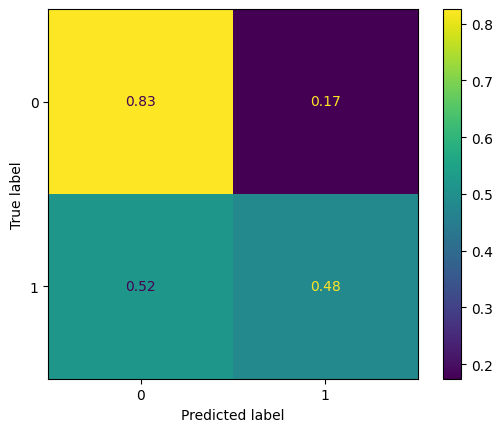

In [106]:
from classifier import run_and_compare
run_and_compare(train_X, train_y, test_X, test_y, model='svm')

# SVM Accuracies

Note that these will probably be slightly different each time based on the data split. I just wrote these down for a general idea of the best params. 

200 components: 
- Hinge — 0.6432888166607337
- log_loss — 0.6371600030709288
- huber — 0.6045798030541624
- epsilon_insensitive -- 0.6243449925510459
- modified_huber — 0.6607661267904723
- squared_hinge — 0.6525500834455048
- perceptron — 0.5963679298868061 (really good for 0s, but probably because it might just be guessing 0s a ton and getting a high hit rate) 

175 components:
- Hinge — 0.6468060525314879
- log_loss — 0.6172351771686619
- huber — 0.6247846510249453
- epsilon_insensitive -- 0.6245843411376562
    - Did a great job predicting defaults (0.84) 
- modified_huber — 0.6557343207158701
- squared_hinge — 0.5492138711315983
- perceptron — 0.5041903878103752 (lol now I KNOW this shit is just guessing 1)

150 components: 
- Hinge — 0.6453322424507427
- log_loss — 0.591766431876927
- huber — 0.61793966358117
- epsilon_insensitive -- 0.6354215862146304
    - Did a great job predicting defaults (0.78) 
- modified_huber — 0.6425852080603528
- squared_hinge — 0.5466302351985645
- perceptron — 0.6012018087070353


baseline balanced-accuracy-score: 0.5
Running Logistic Regression Classifier ....
lr balanced accuracy: 0.6804043367731287
lr f1 score: 0.7549371108783756
lr precision score: 0.8954416417874173


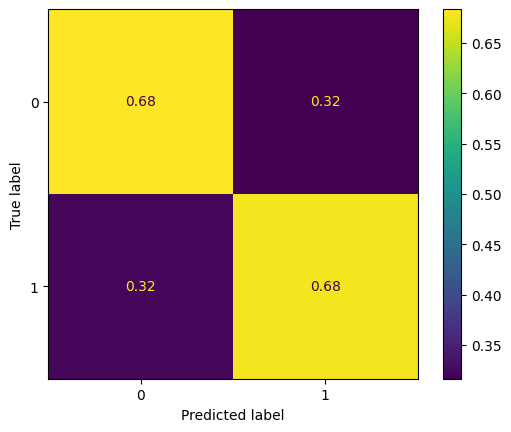

In [107]:
from classifier import run_and_compare
run_and_compare(train_X, train_y, test_X, test_y, model='lr')

# LR Accuracies:

Note that these will probably be slightly different each time based on the data split. I just wrote these down for a general idea of the best params. 

150 Components:
- C 0.25 — 0.6628742530343206
- C 0.5 — 0.6681524393126752
- C 0.75 — 0.6702277034625324
- C 1 — 0.6721468834960813
- C 1.25 — 0.6723835348054287
- C 1.5 — 0.6737241591262073
- C 1.75 — 0.6741726230817547
- C 2 — 0.6736864770456279
- C 5 — 0.6760685536341112
- C 10 — 0.6752884385767906
- C 50 — 0.6750325871221924

200 Components:
- C 0.25 — 0.6663838348393336
- C 0.5 — 0.6710626760777125
- C 0.75 — 0.6734488020021376
- C 1 — 0.6737931665595478
- C 1.25 — 0.6733738733269949
- C 1.5 — 0.6753873349430477
- C 1.75 — 0.6755968401973712
- C 2 — 0.6757949384541065
- C 5 — 0.6754746943499215
- C 10 — 0.6759695045057436
- C 50 — 0.6751665754532465


baseline balanced-accuracy-score: 0.5
Running Random Forest Classifier ....
rf balanced accuracy: 0.6310891364816641
rf f1 score: 0.8358487720898181
rf precision score: 0.8820199577579223


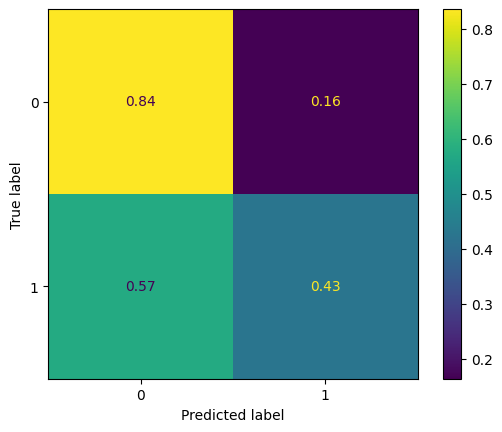

In [108]:
from classifier import run_and_compare
run_and_compare(train_X, train_y, test_X, test_y, model='rf')

baseline balanced-accuracy-score: 0.5
Running Voting Classifier ....
voting balanced accuracy: 0.6773375576054519
voting f1 score: 0.7484612054103711
voting precision score: 0.895062673299254
voting roc auc score: 0.7391365391208535


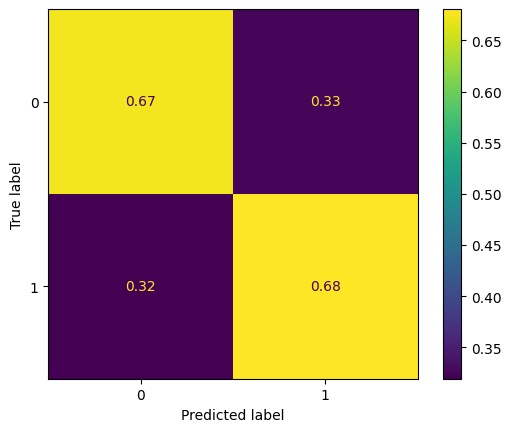

In [76]:
# from classifier import run_and_compare
# run_and_compare(train_X, train_y, test_X, test_y, model='voting')